# Lunar Lander Deep-q network

In [1]:
import gym
import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt

max_epochs = 500
mem_size = 100000
blank = 20

env = gym.make("LunarLander-v2")

Using TensorFlow backend.


In [2]:
from collections import deque

class Memory:
    def __init__(self, size, samplesize):
        self.samplesize = samplesize
        self.memory = deque(maxlen=size)
        self.size = size
    
    def remember(self, experience):
        self.memory.append(experience)
    
    def sample(self):
        indecies = np.random.choice(np.arange(self.size), size=self.samplesize, replace = False)
        return [self.memory[index] for index in indecies]       
        

In [3]:
class Agent_q():
    def __init__(self, state_dim, action_dim):
       
        self.model = Sequential()
        self.model.add(Dense(128, activation='relu', input_shape=(state_dim,)))
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(action_dim, activation = 'linear'))
        adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        self.model.compile(optimizer= adam, loss='logcosh', metrics=['accuracy'])
        
    def predict(self, state):
        return np.argmax(self.model.predict(np.array([state])))
    
    def train(self, experiences):
        state, action, reward, next_state = zip(*experiences)
        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        
        next_q_vals = self.model.predict(next_state)
        mask = to_categorical(action)
        
        target = mask*reward[:,np.newaxis] + mask *0.99 * np.max(next_q_vals)
        self.model.fit(state, target, batch_size=100, verbose = 0)

Prepopulating memory:
____________________
||||||||||||||||||||Training:
____________________
||||||||||||||||||||

Text(0,0.5,'Average Reward')

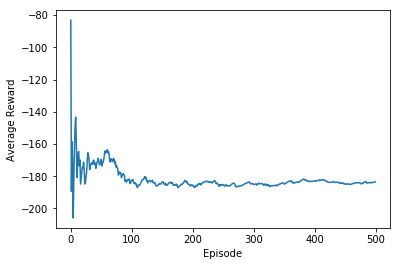

In [4]:
memory = Memory(mem_size,200)
agent = Agent_q(env.observation_space.shape[0], env.action_space.n)
epsilon = 0.2
epsilon_decay = 0.99

print("Prepopulating memory:")
print("____________________")
state = env.reset()
for step in range(mem_size):
    if step%(mem_size/blank)==0:
        print("|", end='')
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.remember((state, action, reward, next_state))
    if done:
        state = env.reset()
    else:
        state = next_state
     
av_reward = []     
epoch_reward = 0
env.reset()
print("\nTraining:")
print("____________________")
for epoch in range(1,max_epochs+1):
    done = False
    state = env.reset()
    while not done:
        if np.random.uniform():
            action = env.action_space.sample()
        else:
            action = agent.predict(state)
        epsilon*=epsilon_decay
        
        next_state, reward, done, _ = env.step(action)
        memory.remember((state, action, reward, next_state))
        epoch_reward += reward
        if done:
            av_reward.append(epoch_reward/epoch)
            if epoch%(max_epochs/blank)==0:
                print("|", end='')
            agent.train(memory.sample())
            break
        else:
            state = next_state
    
plt.plot(av_reward)
plt.xlabel('Episode')
plt.ylabel('Average Reward')

In [5]:
state = env.reset()
done = False
while not done:
    action = agent.predict(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    if done:
        env.close()
    else:
        state = next_state